In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0604/weights_KD_segformer_0604_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 5s 563ms/step - loss: 0.0227
Average validation loss: 0.6092686057090759
4/4 [==============================] - 5s 578ms/step - loss: 0.0227 - val_loss: 0.6093
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 7s 568ms/step - loss: 0.0141 - val_loss: 0.6093
Average validation loss: 0.5739498138427734
4/4 [==============================] - 7s 580ms/step - loss: 0.0141 - val_loss: 0.5916
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 9s 560ms/step - loss: 0.0100 - val_loss: 0.5916
Average validation loss: 0.5013773441314697
4/4 [==============================] - 9s 573ms/step - loss: 0.0100 - val_loss: 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 5s 655ms/step - loss: 5.4296e-07
Average validation loss: 0.00044410943519324064
8/8 [==============================] - 5s 667ms/step - loss: 5.4296e-07 - val_loss: 4.4411e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 669ms/step - loss: 5.2484e-07 - val_loss: 4.4411e-04
Average validation loss: 7.201762127806433e-05
8/8 [==============================] - 11s 683ms/step - loss: 5.2484e-07 - val_loss: 2.5806e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 16s 678ms/step - loss: 5.1481e-07 - val_loss: 2.5806e-04
Average validation loss: 0.0007573567563667893
8/8 [========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 679ms/step - loss: 2.9104e-06
Average validation loss: 0.17275304595629373
12/12 [==============================] - 8s 688ms/step - loss: 2.9104e-06 - val_loss: 0.1728
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 683ms/step - loss: 3.0536e-06 - val_loss: 0.1728
Average validation loss: 0.05916092460404343
12/12 [==============================] - 17s 694ms/step - loss: 3.0536e-06 - val_loss: 0.1160
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 25s 674ms/step - loss: 3.0868e-06 - val_loss: 0.1160
Average validation loss: 0.03867449722262487
12/12 [==============================] - 2

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 669ms/step - loss: 2.6961e-06
Average validation loss: 0.07757569806710762
16/16 [==============================] - 11s 680ms/step - loss: 2.6961e-06 - val_loss: 0.0776
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 22s 685ms/step - loss: 2.6112e-06 - val_loss: 0.0776
Average validation loss: 0.06979062577897821
16/16 [==============================] - 22s 696ms/step - loss: 2.6112e-06 - val_loss: 0.0737
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 33s 684ms/step - loss: 2.5272e-06 - val_loss: 0.0737
Average validation loss: 0.1217708407274074
16/16 [==============================] - 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 699ms/step - loss: 6.1741e-07
Average validation loss: 0.04084175601601601
20/20 [==============================] - 14s 709ms/step - loss: 6.1741e-07 - val_loss: 0.0408
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 28s 691ms/step - loss: 5.7124e-07 - val_loss: 0.0408
Average validation loss: 0.04190778639167547
20/20 [==============================] - 28s 702ms/step - loss: 5.7124e-07 - val_loss: 0.0414
Epoch 3/10
20/20 [==============================] - 42s 685ms/step - loss: 5.4213e-07 - val_loss: 0.0414
Average validation loss: 0.04151060134172439
20/20 [==============================] - 42s 695ms/step - loss: 5.4213e-07 - val_loss: 0.0414
Epoch 4/10
20/20 [==============================] - 56s 683ms/step - loss: 5.2184e-07 - val_loss: 0.0414
Average validatio

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 723ms/step - loss: 7.5458e-07
Average validation loss: 0.046265615771214165
24/24 [==============================] - 18s 732ms/step - loss: 7.5458e-07 - val_loss: 0.0463
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 706ms/step - loss: 7.4105e-07 - val_loss: 0.0463
Average validation loss: 0.06448657872776191
24/24 [==============================] - 35s 716ms/step - loss: 7.4105e-07 - val_loss: 0.0554
Epoch 3/10
24/24 [==============================] - 51s 687ms/step - loss: 6.8096e-07 - val_loss: 0.0554
Average validation loss: 0.06297792370120685
24/24 [==============================] - 52s 698ms/step - loss: 6.8096e-07 - val_loss: 0.0579
Epoch 4/10
24/24 [==============================] - 69s 705ms/step - loss: 6.4991e-07 - val_loss: 0.0579
Average validati

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 27s 682ms/step - loss: 1.7656e-06
Average validation loss: 0.06387111283838749
40/40 [==============================] - 28s 692ms/step - loss: 1.7656e-06 - val_loss: 0.0639
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 55s 682ms/step - loss: 1.6891e-06 - val_loss: 0.0639
Average validation loss: 0.07183526176959276
40/40 [==============================] - 55s 692ms/step - loss: 1.6891e-06 - val_loss: 0.0679
Epoch 3/10
40/40 [==============================] - 83s 692ms/step - loss: 1.4663e-06 - val_loss: 0.0679
Average validation loss: 0.0751540869474411
40/40 [==============================] - 84s 702ms/step - loss: 1.4663e-06 - val_loss: 0.0703
Epoch 4/10
40/40 [==============================] - 111s 690ms/step - loss: 1.4046e-06 - val_loss: 0.0703
Average validatio

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 33s 689ms/step - loss: 8.0803e-07
Average validation loss: 0.033819656586274505
48/48 [==============================] - 34s 699ms/step - loss: 8.0803e-07 - val_loss: 0.0338
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 67s 700ms/step - loss: 5.4979e-07 - val_loss: 0.0338
Average validation loss: 0.03882196790073067
48/48 [==============================] - 68s 710ms/step - loss: 5.4979e-07 - val_loss: 0.0363
Epoch 3/10
48/48 [==============================] - 101s 690ms/step - loss: 4.3818e-07 - val_loss: 0.0363
Average validation loss: 0.042890812658394374
48/48 [==============================] - 101s 700ms/step - loss: 4.3818e-07 - val_loss: 0.0385
Epoch 4/10
48/48 [==============================] - 135s 693ms/step - loss: 3.7137e-07 - val_loss: 0.0385
Average vali

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 710ms/step - loss: 1.9026e-06
Average validation loss: 0.061859536616663845
56/56 [==============================] - 40s 720ms/step - loss: 1.9026e-06 - val_loss: 0.0619
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 80s 707ms/step - loss: 1.2639e-06 - val_loss: 0.0619
Average validation loss: 0.02916231841248061
56/56 [==============================] - 81s 717ms/step - loss: 1.2639e-06 - val_loss: 0.0455
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 120s 695ms/step - loss: 9.6883e-07 - val_loss: 0.0455
Average validation loss: 0.050185815148454695
56/56 [==============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 45s 703ms/step - loss: 6.4833e-07
Average validation loss: 0.031238063937053084
64/64 [==============================] - 46s 713ms/step - loss: 6.4833e-07 - val_loss: 0.0312
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 90s 694ms/step - loss: 4.1681e-07 - val_loss: 0.0312
Average validation loss: 0.03471588363754563
64/64 [==============================] - 91s 704ms/step - loss: 4.1681e-07 - val_loss: 0.0330
Epoch 3/10
64/64 [==============================] - 135s 698ms/step - loss: 3.0931e-07 - val_loss: 0.0330
Average validation loss: 0.03565230924868956
64/64 [==============================] - 136s 707ms/step - loss: 3.0931e-07 - val_loss: 0.0339
Epoch 4/10
64/64 [==============================] - 181s 698ms/step - loss: 2.4838e-07 - val_loss: 0.0339
Average valid

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 50s 695ms/step - loss: 8.4219e-07
Average validation loss: 0.04124773195427325
72/72 [==============================] - 51s 705ms/step - loss: 8.4219e-07 - val_loss: 0.0412
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 101s 700ms/step - loss: 5.5220e-07 - val_loss: 0.0412
Average validation loss: 0.03273575220050083
72/72 [==============================] - 102s 710ms/step - loss: 5.5220e-07 - val_loss: 0.0370
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 152s 694ms/step - loss: 4.3239e-07 - val_loss: 0.0370
Average validation loss: 0.04418288295467695
72/72 [==============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 56s 704ms/step - loss: 5.0513e-07
Average validation loss: 0.032886245660483836
80/80 [==============================] - 57s 714ms/step - loss: 5.0513e-07 - val_loss: 0.0329
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 114s 707ms/step - loss: 3.8708e-07 - val_loss: 0.0329
Average validation loss: 0.033381431642919776
80/80 [==============================] - 114s 717ms/step - loss: 3.8708e-07 - val_loss: 0.0331
Epoch 3/10
80/80 [==============================] - 172s 714ms/step - loss: 2.9890e-07 - val_loss: 0.0331
Average validation loss: 0.03371285879984498
80/80 [==============================] - 172s 724ms/step - loss: 2.9890e-07 - val_loss: 0.0333
Epoch 4/10
80/80 [==============================] - 229s 708ms/step - loss: 2.4490e-07 - val_loss: 0.0333
Average v

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 68s 705ms/step - loss: 1.4165e-06
Average validation loss: 0.07263620075051828
96/96 [==============================] - 69s 715ms/step - loss: 1.4165e-06 - val_loss: 0.0726
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 136s 705ms/step - loss: 8.5867e-07 - val_loss: 0.0726
Average validation loss: 0.05031031199905556
96/96 [==============================] - 137s 715ms/step - loss: 8.5867e-07 - val_loss: 0.0615
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 205s 708ms/step - loss: 6.2112e-07 - val_loss: 0.0615
Average validation loss: 0.05275792673152561
96/96 [============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 85s 711ms/step - loss: 7.0141e-07
Average validation loss: 0.03849364889319986
120/120 [==============================] - 86s 721ms/step - loss: 7.0141e-07 - val_loss: 0.0385
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 171s 706ms/step - loss: 4.1318e-07 - val_loss: 0.0385
Average validation loss: 0.03199686192286511
120/120 [==============================] - 172s 716ms/step - loss: 4.1318e-07 - val_loss: 0.0352
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 257s 703ms/step - loss: 2.9978e-07 - val_loss: 0.0352
Average validation loss: 0.02825322252077361
120/120 [================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 102s 706ms/step - loss: 4.1185e-07
Average validation loss: 0.032686855592247516
144/144 [==============================] - 103s 716ms/step - loss: 4.1185e-07 - val_loss: 0.0327
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 205s 705ms/step - loss: 2.5221e-07 - val_loss: 0.0327
Average validation loss: 0.029797088199605543
144/144 [==============================] - 206s 714ms/step - loss: 2.5221e-07 - val_loss: 0.0312
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 307s 703ms/step - loss: 1.9233e-07 - val_loss: 0.0312
Average validation loss: 0.03349688628481494
144/144 [============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 111s 692ms/step - loss: 1.7585e-07
Average validation loss: 0.025780110948835498
160/160 [==============================] - 112s 702ms/step - loss: 1.7585e-07 - val_loss: 0.0258
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 222s 684ms/step - loss: 1.2243e-07 - val_loss: 0.0258
Average validation loss: 0.029759635261143558
160/160 [==============================] - 223s 694ms/step - loss: 1.2243e-07 - val_loss: 0.0278
Epoch 3/10
160/160 [==============================] - 334s 689ms/step - loss: 9.7530e-08 - val_loss: 0.0278
Average validation loss: 0.0243255380919436
160/160 [==============================] - 335s 699ms/step - loss: 9.7530e-08 - val_loss: 0.0266
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 139s 695ms/step - loss: 2.0423e-06
Average validation loss: 0.030633518821559846
200/200 [==============================] - 141s 705ms/step - loss: 2.0423e-06 - val_loss: 0.0306
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 280s 692ms/step - loss: 1.1468e-06 - val_loss: 0.0306
Average validation loss: 0.02982956138905138
200/200 [==============================] - 282s 702ms/step - loss: 1.1468e-06 - val_loss: 0.0302
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 421s 698ms/step - loss: 8.1489e-07 - val_loss: 0.0302
Average validation loss: 0.02758830263512209
200/200 [=============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:46 - loss: 6.0167e-08

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 171s 711ms/step - loss: 1.3665e-06
Average validation loss: 0.04816470746979273
240/240 [==============================] - 173s 721ms/step - loss: 1.3665e-06 - val_loss: 0.0482
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 342s 705ms/step - loss: 8.4848e-07 - val_loss: 0.0482
Average validation loss: 0.039867026880771546
240/240 [==============================] - 345s 715ms/step - loss: 8.4848e-07 - val_loss: 0.0440
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 515s 708ms/step - loss: 6.2198e-07 - val_loss: 0.0440
Average validation loss: 0.04014426665768648
240/240 [=============

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.09429017117101467, 0.03936706605952168, 0.10557261710604043, 0.06660326406327328, 0.05284477732330561, 0.048097585396220284, 0.050531172270886604, 0.03712004982555906, 0.03472547096383226, 0.05906140862876427, 0.03244797024759463, 0.027051926896558144, 0.03934222304781239, 0.03377098857766638, 0.026264765644543026, 0.01985484227206325, 0.023570826306601518, 0.03154930056238421]
std_val_losses =  [0.14702004695658946, 0.034428800850901414, 0.05965166155852269, 0.023919857798396015, 0.020317543124403162, 0.026010414894258052, 0.01582978781013848, 0.007950503887972131, 0.01282809472991109, 0.04843053457858757, 0.006215502592330953, 0.004192205446837589, 0.013243027228564705, 0.01330365245035209, 0.00615456247515798, 0.0040741425099277955, 0.00626616448604008, 0.014520526334819789]


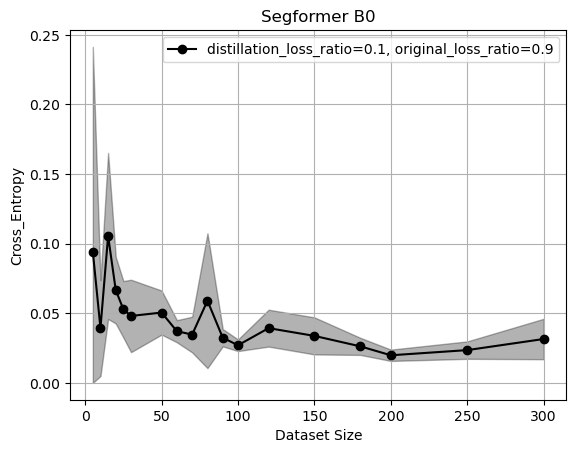

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0604')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.png"))

plt.show()